In [15]:
%matplotlib inline
import numpy as np
import pandas as pd
import graphviz
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


data = pd.read_csv(r"../data/train.csv")
del data['Id']

X = data.loc[:, data.columns != 'Cover_Type'].values
Y = data['Cover_Type'].values

data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [3]:
# utils
def k_fold(k, X, Y, total_classes=7):
    fold_per_class_size = (len(Y) // k) // total_classes
    class_sample_size = len(Y) // total_classes
    
    sort_idxs = Y.argsort()
    folds = [([], []) for _ in range(k)]
    for i in range(total_classes):
        class_idxs = np.random.permutation(sort_idxs[i * class_sample_size: (i + 1) * class_sample_size])
        for j in range(k - 1):
            folds[j][0].extend(X[class_idxs[j * fold_per_class_size: (j + 1) * fold_per_class_size]])
            folds[j][1].extend(Y[class_idxs[j * fold_per_class_size: (j + 1) * fold_per_class_size]])
        folds[k - 1][0].extend(X[class_idxs[(k - 1) * fold_per_class_size:]])
        folds[k - 1][1].extend(Y[class_idxs[(k - 1) * fold_per_class_size:]])
        
    return folds


def to_train_test(folds, test_fold_idx):
    test_x = np.array(folds[test_fold_idx][0])
    test_y = np.array(folds[test_fold_idx][1])
    train_x = np.concatenate([folds[i][0] for i in range(len(folds)) if i != test_fold_idx], axis=0)
    train_y = np.concatenate([folds[i][1] for i in range(len(folds)) if i != test_fold_idx], axis=0)
    return (train_x, train_y), (test_x, test_y)


def precision_recall(Y, Y_pred):
    classes, frequencies = np.unique(Y, return_counts=True)
    tp_fp_per_class = {c:[0, 0] for c in classes}
    for y, y_pred in zip(Y, Y_pred):
        if y == y_pred:
            # true positive
            tp_fp_per_class[y_pred][0] += 1
        else:
            # false positive
            tp_fp_per_class[y_pred][1] += 1
    return {c:[
                tp_fp_per_class[c][0] / sum(tp_fp_per_class[c]),
                tp_fp_per_class[c][0] / counter
            ] 
            for c, counter in zip(classes, frequencies)
           }

def plot_precision_recall(pr):
    fig, ax = plt.subplots()
    index = np.arange(len(pr))
    bar_width = 0.35
    opacity = 0.8

    rects1 = ax.bar(index, [v[0] for v in pr.values()], bar_width,
    alpha=opacity,
    color='b',
    label='Precision')

    rects2 = ax.bar(index + bar_width, [v[1] for v in pr.values()], bar_width,
    alpha=opacity,
    color='g',
    label='Recall')

    ax.set_xlabel('Class')
    ax.set_ylabel('Percent')
    ax.set_title('Precision Recall')
    ax.set_xticks(index + bar_width, [str(c) for c in pr])
    ax.legend()

    fig.tight_layout()
    return ax

from scikitplot.metrics import plot_confusion_matrix

[INFO] Fold #0
	Decision tree precision: 0.7738


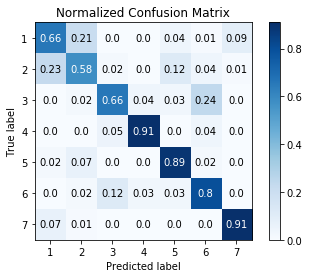

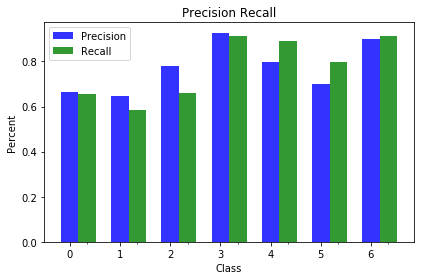

[INFO] Fold #1
	Decision tree precision: 0.7854


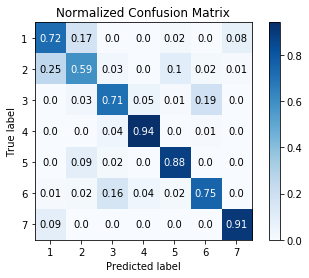

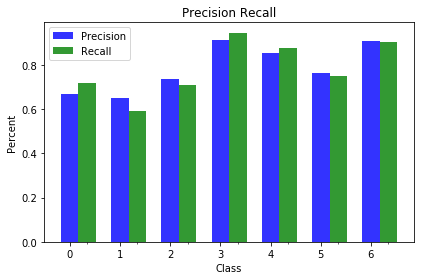

[INFO] Fold #2
	Decision tree precision: 0.7788


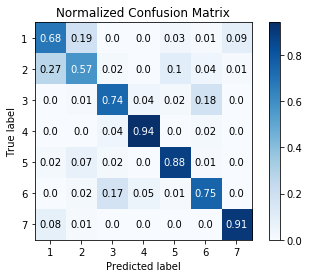

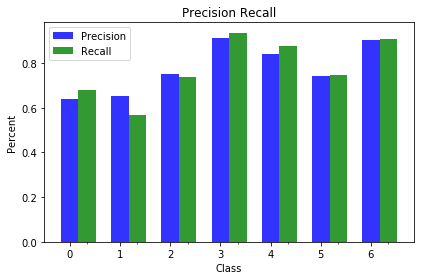

[INFO] Fold #3
	Decision tree precision: 0.7960


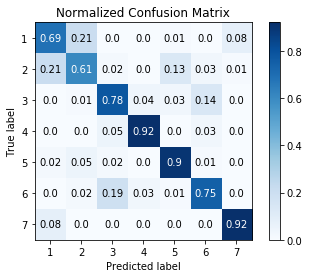

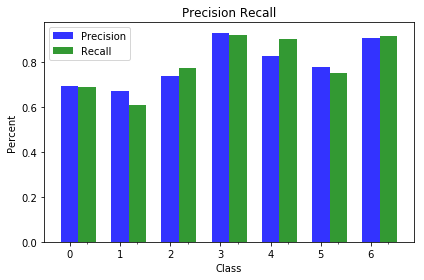

[INFO] Fold #4
	Decision tree precision: 0.7794


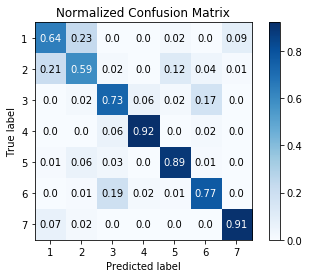

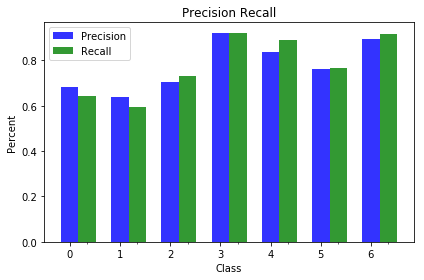

In [6]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
_X = X[:, :].astype(np.float32)
k = 5
folds = k_fold(k, _X, Y)

for i in range(k):
    print("[INFO] Fold #%d" % (i, ))
    (train_x, train_y), (test_x, test_y) = to_train_test(folds, i)
    
    dtree = DecisionTreeClassifier(criterion='entropy', max_depth=13, min_impurity_decrease=2.79316138e-04)
    dtree.fit(train_x, train_y)
    print("\tDecision tree precision: %.4f" % (dtree.score(test_x, test_y), ))
    test_y_pred = dtree.predict(test_x)

    plot_confusion_matrix(test_y, test_y_pred, normalize=True)
    plot_precision_recall(precision_recall(test_y, test_y_pred))
    plt.show()
        

In [4]:
from scipy.optimize import differential_evolution
from math import exp

k = 5
folds = k_fold(k, _X, Y)
(train_x, train_y), (test_x, test_y) = to_train_test(folds, 0)

def dtree_evaluation_function(x):
    dtree = DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=x[0], max_depth=int(x[1]))
    dtree.fit(train_x, train_y)
    test_acc = dtree.score(test_x, test_y)
    train_acc = dtree.score(train_x, train_y)
    return exp((train_acc / test_acc) ** 2 + 1 / test_acc ** 2)
    
res = differential_evolution(
    dtree_evaluation_function, 
    [(1.e-8, 5), (2, 14)], 
    popsize=50, mutation=(0.3, 0.7), recombination=(0.4, 0.6)
)
print(res.x, res.message)



[2.79316138e-04 1.39767360e+01] Optimization terminated successfully.


In [6]:
from os import environ, pathsep
environ["PATH"] += pathsep + r'C:\Program Files (x86)\Graphviz2.38\bin'

dot_data = export_graphviz(dtree, out_file=None, filled=True, rounded=True, special_characters=True) 
graph = graphviz.Source(dot_data)

graph.render()

'Source.gv.pdf'

[INFO] Fold #0
	Naive Bayes accuracy 0.4124


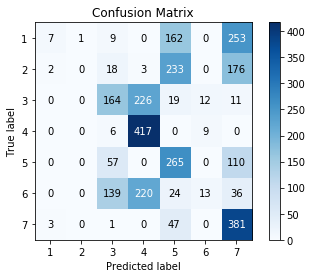

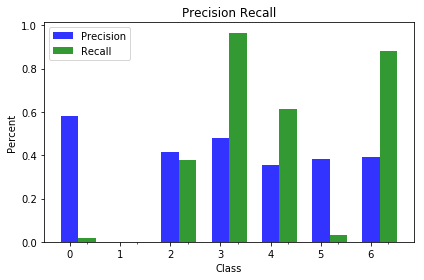

[INFO] Fold #1
	Naive Bayes accuracy 0.4279


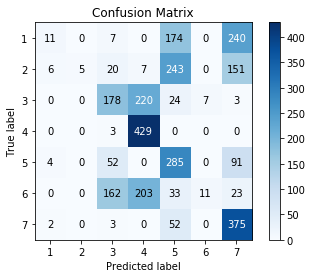

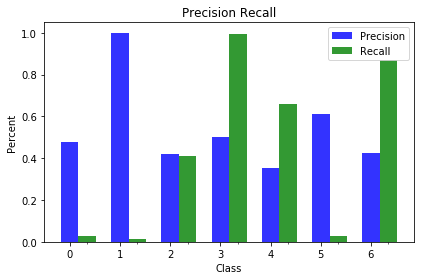

[INFO] Fold #2
	Naive Bayes accuracy 0.4507


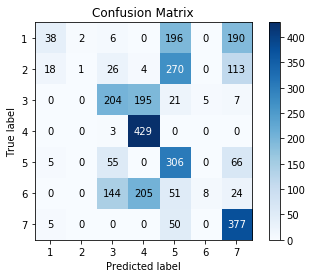

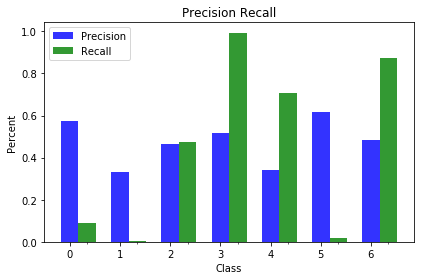

[INFO] Fold #3
	Naive Bayes accuracy 0.4296


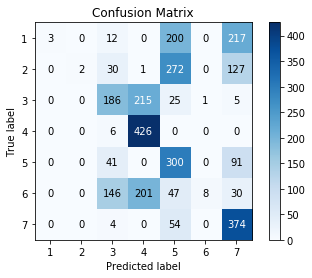

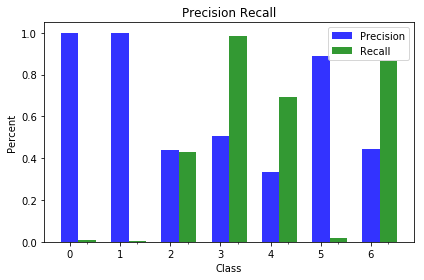

[INFO] Fold #4
	Naive Bayes accuracy 0.4263


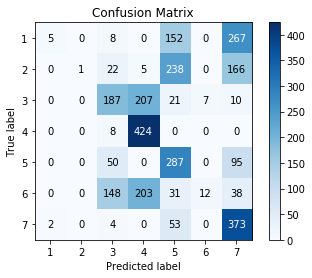

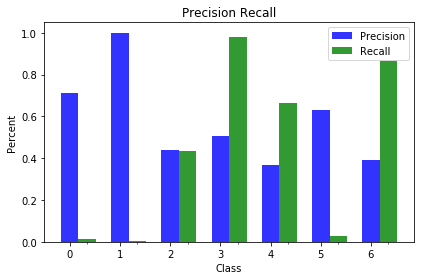

In [35]:
# naive bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

total_features = 2 ** _X.shape[1] - 1
idxs = [idx for idx, b in enumerate(bin(int(total_features * 0.45588818))[:1:-1]) if b == '1']
_X = X[:, idxs].astype(np.float32)



# pca_components = pca.fit(_X).components_
# _X = _X.dot(pca_components.T)

k = 5
folds = k_fold(k, _X, Y)

for i in range(k):
    print("[INFO] Fold #%d" % (i, ))
    (train_x, train_y), (test_x, test_y) = to_train_test(folds, i)
    
    gnb = GaussianNB()
    gnb.fit(train_x, train_y)
    print("\tNaive Bayes accuracy %.4f" % (gnb.score(test_x, test_y), ))

    test_y_pred = gnb.predict(test_x)
    plot_confusion_matrix(test_y, test_y_pred, normalize=False)
    plot_precision_recall(precision_recall(test_y, test_y_pred))
    plt.show()


In [18]:
from scipy.optimize import differential_evolution
from math import exp

k = 5
_X = X[:, :].astype(np.float64)
folds = k_fold(k, _X, Y)
(train_x, train_y), (test_x, test_y) = to_train_test(folds, 0)
total_features = 2 ** _X.shape[1] - 1

def evaluation_function_gnb(x, *args):
    idxs = [idx for idx, b in enumerate(bin(int(total_features * x[0]))[:1:-1]) if b == '1']
    
    gnb = GaussianNB()
    gnb.fit(train_x[:, idxs], train_y)
    test_acc = gnb.score(test_x[:, idxs], test_y)
    return exp(1 / test_acc ** 2)
    
res = differential_evolution(
    evaluation_function_gnb, 
    [(1 / total_features, 1)], 
    popsize=20
)
print(res.x, res.message)

[0.45588818] Optimization terminated successfully.


In [36]:
from scipy.optimize import differential_evolution
from sklearn.neighbors import KNeighborsClassifier
from math import exp

k = 5
_X = X[:, :].astype(np.float64)
folds = k_fold(k, _X, Y)
(train_x, train_y), (test_x, test_y) = to_train_test(folds, 0)

def evaluation_function_knn(x, *args):
    
    knn = KNeighborsClassifier(n_neighbors=int(x[0]))
    knn.fit(train_x, train_y)

    test_acc = knn.score(test_x, test_y)
    return exp(1 / test_acc ** 3 + (1 / x[0]) ** 2)
    
res = differential_evolution(
    evaluation_function_knn, 
    [(1, 20)], 
    popsize=30
)
print(res.x, res.message)
neighbours = int(res.x)

[3.99999696] Optimization terminated successfully.


[INFO] Fold #0
	kNN accuracy: 0.8313


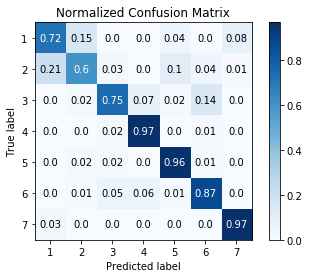

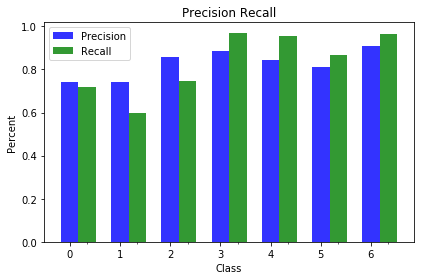

[INFO] Fold #1
	kNN accuracy: 0.8211


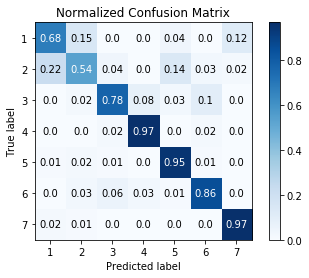

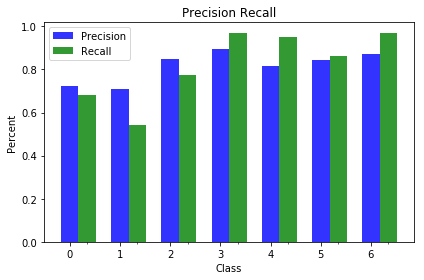

[INFO] Fold #2
	kNN accuracy: 0.8224


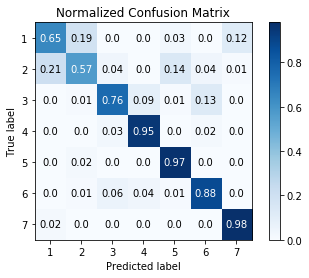

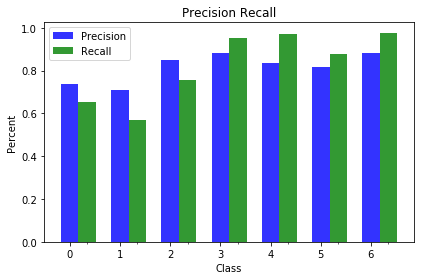

[INFO] Fold #3
	kNN accuracy: 0.8300


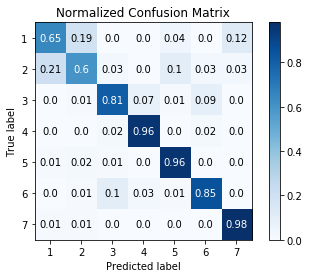

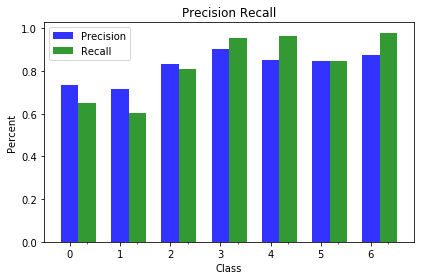

[INFO] Fold #4
	kNN accuracy: 0.8148


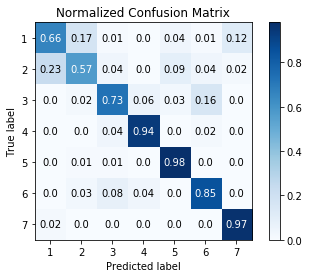

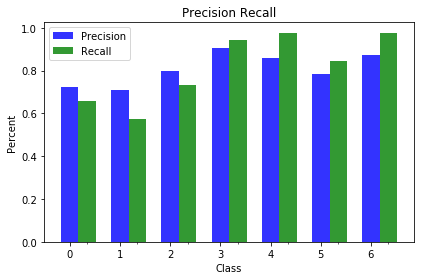

In [37]:
from sklearn.neighbors import KNeighborsClassifier

k = 5
folds = k_fold(k, X, Y)

for i in range(k):
    print("[INFO] Fold #%d" % (i, ))
    (train_x, train_y), (test_x, test_y) = to_train_test(folds, i)

    knn = KNeighborsClassifier(n_neighbors=neighbours if 'neighbours' in vars() or 'neighbours' in globals() else 3)
    knn.fit(train_x, train_y)

    print("\tkNN accuracy: %.4f" % (knn.score(test_x, test_y)))
    test_y_pred = knn.predict(test_x)
    plot_confusion_matrix(test_y, test_y_pred, normalize=True)
    plot_precision_recall(precision_recall(test_y, test_y_pred))
    plt.show()

[INFO] Fold #0
	[TRAIN] Neural network accuracy: 0.8832
	[TEST] Neural network accuracy: 0.8188


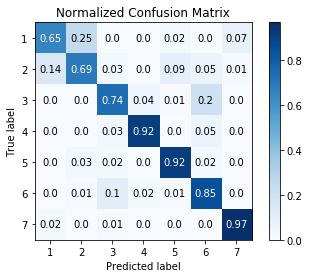

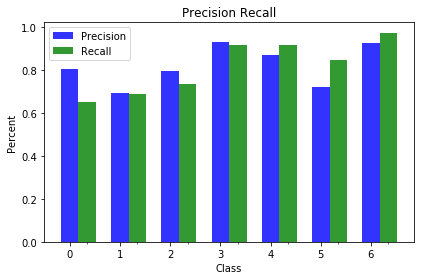

[INFO] Fold #1
	[TRAIN] Neural network accuracy: 0.8844
	[TEST] Neural network accuracy: 0.8307


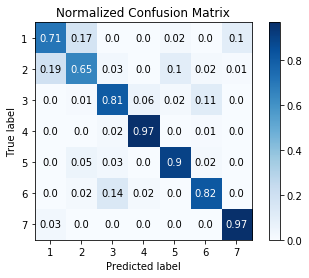

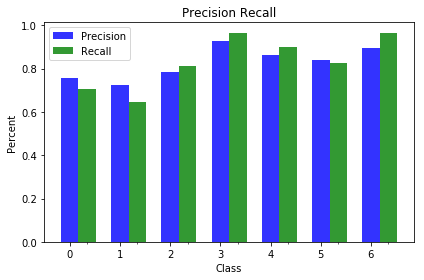

[INFO] Fold #2
	[TRAIN] Neural network accuracy: 0.8765
	[TEST] Neural network accuracy: 0.8254


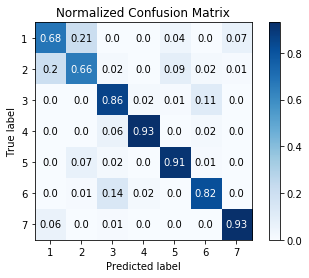

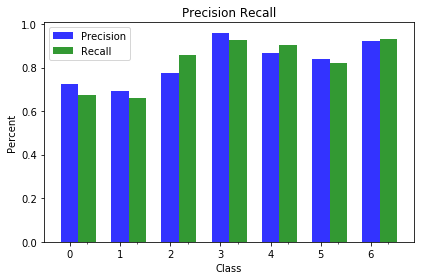

[INFO] Fold #3
	[TRAIN] Neural network accuracy: 0.8781
	[TEST] Neural network accuracy: 0.8343


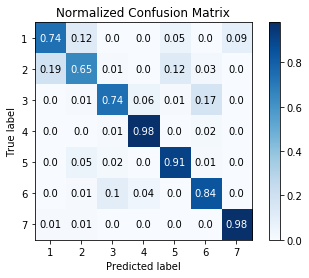

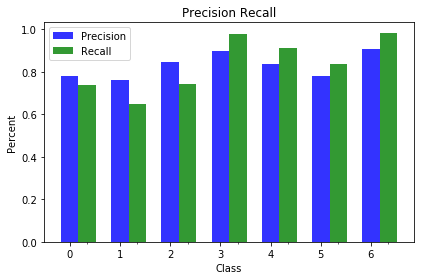

[INFO] Fold #4
	[TRAIN] Neural network accuracy: 0.8760
	[TEST] Neural network accuracy: 0.8218


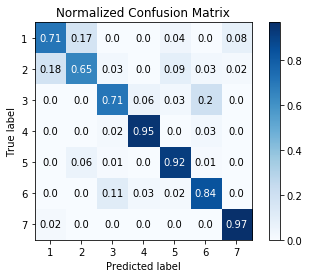

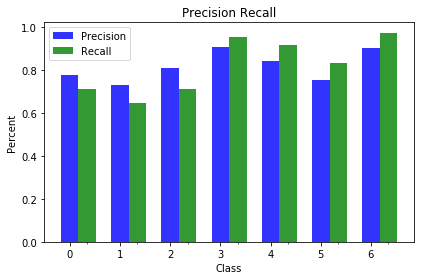

In [19]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, ReLU, ELU, Activation, LeakyReLU, Dropout
from keras.utils import to_categorical
from keras import backend as K
from keras.constraints import max_norm
from sklearn.decomposition import PCA

pca = PCA(n_components=7)
_X = X[:, :].astype(np.float32) / 1.0
# pca_components = pca.fit(_X).components_
# _X = _X.dot(pca_components.T)
# _X = (_X - np.mean(_X, axis=0))
# _X = _X / np.std(_X, axis=0)

np.random.seed(10);
k = 5
folds = k_fold(k, _X, Y)

K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=128, inter_op_parallelism_threads=128)))
for i in range(k):
    print("[INFO] Fold #%d" % (i, ))
    (train_x, train_y), (test_x, test_y) = to_train_test(folds, i)

    classes = 7
    train_y = to_categorical(train_y - 1, classes)  # label in [1, 7] => -1
    test_y = to_categorical(test_y - 1, classes)  # label in [1, 7] => -1

    model = Sequential([
        BatchNormalization(input_shape=(train_x.shape[1], )),
        Dense(units=256),
        ReLU(),
        BatchNormalization(),
        Dense(units=196),
        ReLU(),
        BatchNormalization(),
        Dense(units=128),
        ReLU(),
        BatchNormalization(),
        Dense(units=96),
        ReLU(),
        BatchNormalization(),
        Dense(units=7, activation="softmax"),
    ])

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    model.fit(
        train_x, train_y, epochs=12, batch_size=70, verbose=0, 
        class_weight=[3 / 16, 3 / 16, 2 / 16, 2 / 16, 2 / 16, 2 / 16, 2 / 16]
    )

    print("\t[TRAIN] Neural network accuracy: %.4f" % (model.evaluate(train_x, train_y, batch_size=128, verbose=0)[1]))
    print("\t[TEST] Neural network accuracy: %.4f" % (model.evaluate(test_x, test_y, batch_size=128, verbose=0)[1]))
    test_y_pred = np.argmax(model.predict(test_x), axis=1) + 1
    test_y = np.argmax(test_y, axis=1) + 1
    plot_confusion_matrix(test_y, test_y_pred, normalize=True)
    plot_precision_recall(precision_recall(test_y, test_y_pred))
    plt.show()

[INFO] Fold #0
	SVM accuracy: 0.7116


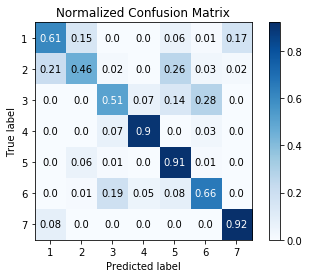

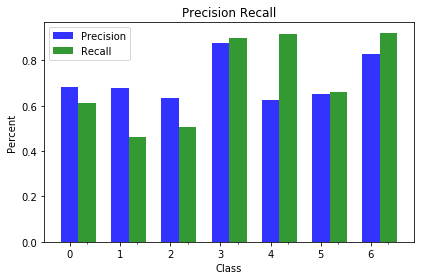

[INFO] Fold #1
	SVM accuracy: 0.7014


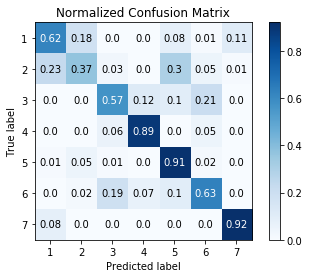

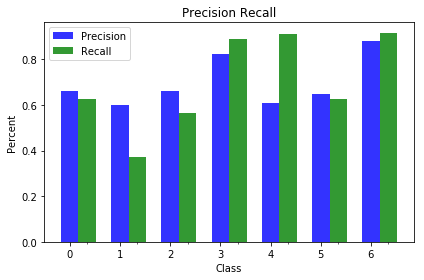

[INFO] Fold #2
	SVM accuracy: 0.7044


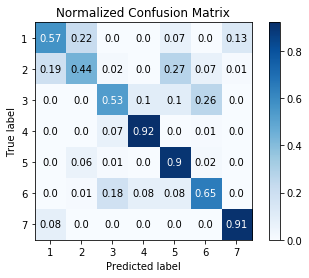

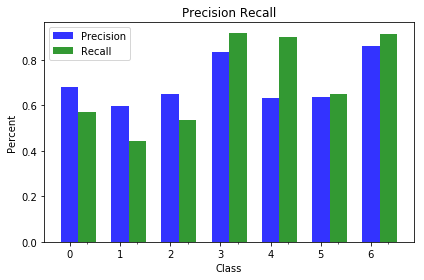

[INFO] Fold #3
	SVM accuracy: 0.7149


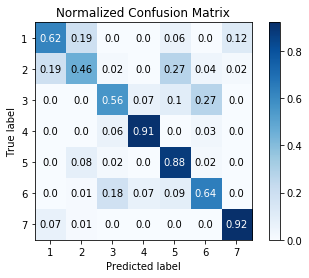

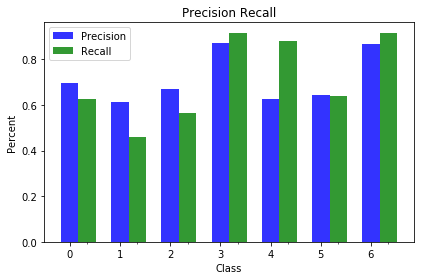

[INFO] Fold #4
	SVM accuracy: 0.7242


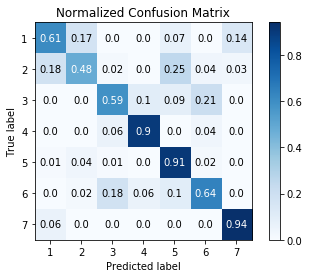

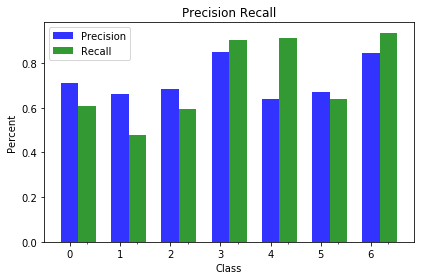

In [34]:
from sklearn.svm import SVC

k = 5
folds = k_fold(k, _X, Y)

for i in range(k):
    print("[INFO] Fold #%d" % (i, ))
    (train_x, train_y), (test_x, test_y) = to_train_test(folds, i)
    
    svm_classifier = SVC(kernel='poly', degree=3, gamma='scale', cache_size=2048)
    svm_classifier.fit(train_x, train_y)
    print("\tSVM accuracy: %.4f" % (svm_classifier.score(test_x, test_y)))
    
    test_y_pred = svm_classifier.predict(test_x)
    plot_confusion_matrix(test_y, test_y_pred, normalize=True)
    plot_precision_recall(precision_recall(test_y, test_y_pred))
    plt.show()

[INFO] Fold #0
	XGBoost accuracy 0.8714


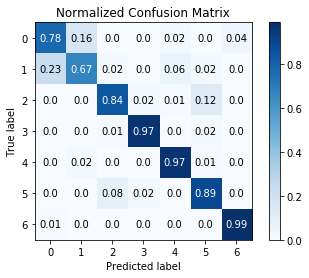

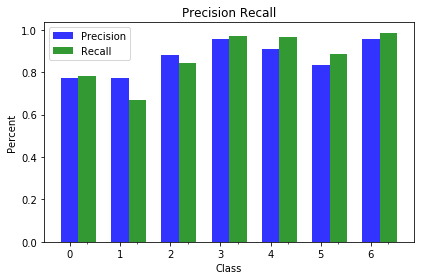

[INFO] Fold #1
	XGBoost accuracy 0.8614


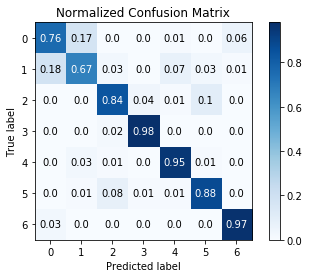

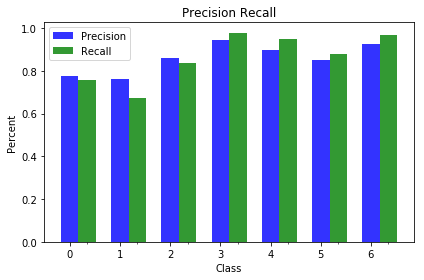

[INFO] Fold #2
	XGBoost accuracy 0.8684


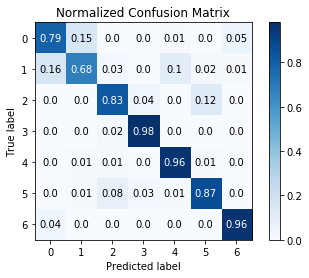

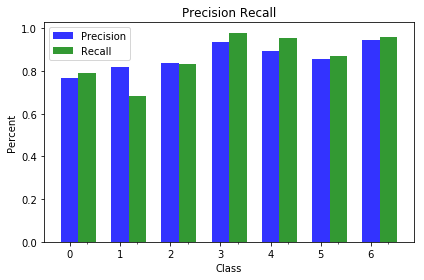

[INFO] Fold #3
	XGBoost accuracy 0.8621


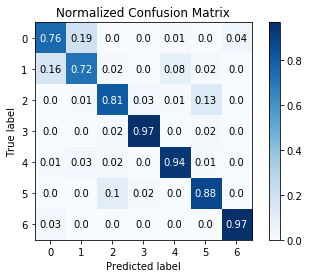

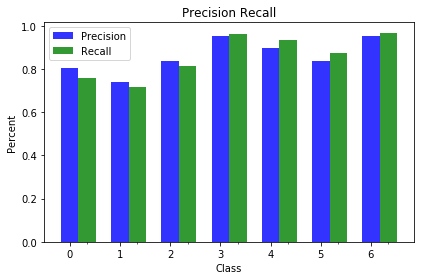

[INFO] Fold #4
	XGBoost accuracy 0.8542


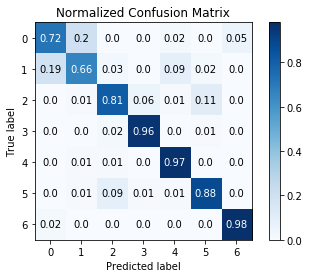

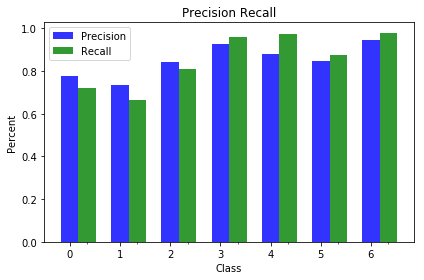

In [5]:
with open('xgboost_results.txt', 'r') as fin:
    lines = fin.readlines()
    for i in range(len(lines) // 2):
        print("[INFO] Fold #%d" % (i, ))
        test_y = list(map(int, lines[2 * i].split(',')))
        test_y_pred = list(map(int, lines[2 * i + 1].split(',')))
        print("\tXGBoost accuracy %.4f" % (sum([y == y_hat for y, y_hat in zip(test_y, test_y_pred)]) / len(test_y)))
        plot_confusion_matrix(test_y, test_y_pred, normalize=True)
        plot_precision_recall(precision_recall(test_y, test_y_pred))
        plt.show()

(15120, 54) int64 (15120, 10) float32
[INFO] Fold #0
[1. 0. 0. 0. 0. 0. 0.]
Epoch 1/10
9991/9991 [==============================] - 17s 2ms/step - loss: 1.0449 - acc: 0.5870
Epoch 2/10
9991/9991 [==============================] - 2s 194us/step - loss: 0.7919 - acc: 0.6816
Epoch 3/10
9991/9991 [==============================] - 2s 191us/step - loss: 0.7555 - acc: 0.6932
Epoch 4/10
9991/9991 [==============================] - 2s 202us/step - loss: 0.7298 - acc: 0.7028
Epoch 5/10
9991/9991 [==============================] - 2s 198us/step - loss: 0.6960 - acc: 0.7159
Epoch 6/10
9991/9991 [==============================] - 2s 195us/step - loss: 0.6862 - acc: 0.7201
Epoch 7/10
9991/9991 [==============================] - 2s 189us/step - loss: 0.6663 - acc: 0.7279
Epoch 8/10
9991/9991 [==============================] - 2s 197us/step - loss: 0.6619 - acc: 0.7307
Epoch 9/10
9991/9991 [==============================] - 2s 192us/step - loss: 0.6437 - acc: 0.7422
Epoch 10/10
9991/9991 [===========

10011/10011 [==============================] - 2s 198us/step - loss: 0.6405 - acc: 0.7326
[INFO] Finish one model

Epoch 1/10
9995/9995 [==============================] - 15s 2ms/step - loss: 1.0907 - acc: 0.5720
Epoch 2/10
9995/9995 [==============================] - 2s 213us/step - loss: 0.7970 - acc: 0.6750
Epoch 3/10
9995/9995 [==============================] - 2s 217us/step - loss: 0.7429 - acc: 0.6973
Epoch 4/10
9995/9995 [==============================] - 2s 212us/step - loss: 0.7053 - acc: 0.7146
Epoch 5/10
9995/9995 [==============================] - 2s 211us/step - loss: 0.6886 - acc: 0.7252
Epoch 6/10
9995/9995 [==============================] - 2s 216us/step - loss: 0.6776 - acc: 0.7291
Epoch 7/10
9995/9995 [==============================] - 2s 217us/step - loss: 0.6653 - acc: 0.7338
Epoch 8/10
9995/9995 [==============================] - 2s 216us/step - loss: 0.6384 - acc: 0.7407
Epoch 9/10
9995/9995 [==============================] - 2s 216us/step - loss: 0.6426 - acc: 0.

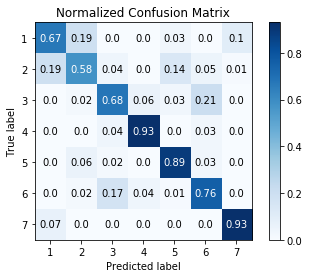

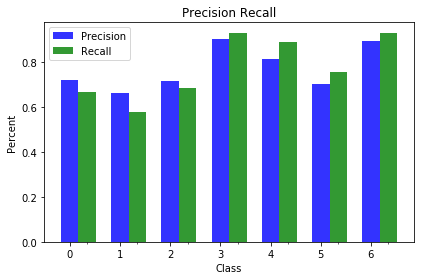

In [23]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, ReLU, ELU, Activation, Dropout
from keras.utils import to_categorical

class Models:
    
    def __init__(self, input_size, total_models, classes=7, stddev=0.06):
        self._classes = classes
        self._stddev = stddev
        self._models = [
            Sequential([
                BatchNormalization(input_shape=(input_size, )),
                Dense(units=156),
                ReLU(),
                BatchNormalization(),
                Dense(units=96),
                ReLU(),
                BatchNormalization(),
                Dense(units=classes, activation="softmax")
            ])
            for _ in range(total_models)
        ]
        
        self._assembler = Sequential([
            # BatchNormalization(input_shape=(total_models * self._classes, )),
            Dense(units=256, input_shape=(total_models * self._classes, )),
            ReLU(),
            BatchNormalization(),
            Dropout(0.1),
            Dense(units=128),
            ReLU(),
            BatchNormalization(),
            Dropout(0.1),
            Dense(units=96),
            ReLU(),
            BatchNormalization(),
            Dropout(0.05),
            Dense(units=classes, activation="softmax"),
        ])
        
        for model in self._models:
            model.compile(
                loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy']
            )
            
        self._assembler.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )
        
    def _to_assembler_X(self, X):
        return np.concatenate([model.predict(X) for model in self._models], axis=1)
        
    def train(self, X, Y, batch_size, epochs):
        cw = [
            [6 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12],
            [1 / 12, 6 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12],
            [1 / 12, 6 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12],
            [6 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12],
            [6 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12],
            [1 / 12, 6 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12],
            [1 / 12, 6 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12],
            [6 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12, 1 / 12]
        ]
        for idx, model in enumerate(self._models):
#             if idx < len(cw):
#                 class_weights = cw[idx]
#             else:
#                 class_weights = np.random.normal(1 / self._classes, self._stddev, self._classes)
#                 # to probabilities
#                 class_weights = class_weights / np.sum(class_weights)
            specialized_class = np.random.choice(self._classes, p=[2/10, 2/10, 2/10, 1/10, 1/10, 1/10, 1/10])
            selection_idxs = [i for i in range(Y.shape[0]) if Y[i][specialized_class] == 1 or np.random.rand() < 0.8]
            model.fit(
                X[selection_idxs], Y[selection_idxs], 
                epochs=epochs, batch_size=batch_size, verbose=1
#                 class_weight=class_weights
            )
            print("[INFO] Finish one model\n")
        print("[INFO] Finish to train models")
        print("[INFO] Begin training of assembler ...")
        
        assembler_X = self._to_assembler_X(X)
        self._assembler.fit(assembler_X, Y, epochs=12, batch_size=batch_size, verbose=1)
            
    def evaluate(self, X, Y):
        assembler_X = self._to_assembler_X(X)
        return self._assembler.evaluate(assembler_X, Y)
    
    def predict(self, X):
        assembler_X = self._to_assembler_X(X)
        return self._assembler.predict(assembler_X)
    

np.random.seed(10);
k = 5
_X = X[:, :10].astype(np.float32) / 1.0
folds = k_fold(k, _X, Y)

for i in range(1):
    print("[INFO] Fold #%d" % (i, ))
    (train_x, train_y), (test_x, test_y) = to_train_test(folds, i)

    classes = 7
    train_y = to_categorical(train_y - 1, classes)  # label in [1, 7] => -1
    test_y = to_categorical(test_y - 1, classes)  # label in [1, 7] => -1
    model = Models(input_size=train_x.shape[1], total_models=10)
    model.train(train_x, train_y, 96, 10)
    
    print("\t[TRAIN] Neural network accuracy: %.4f" % (model.evaluate(train_x, train_y)[1]))
    print("\t[TEST] Neural network accuracy: %.4f" % (model.evaluate(test_x, test_y)[1]))
    
    test_y_pred = np.argmax(model.predict(test_x), axis=1) + 1
    test_y = np.argmax(test_y, axis=1) + 1
    plot_confusion_matrix(test_y, test_y_pred, normalize=True)
    plot_precision_recall(precision_recall(test_y, test_y_pred))
    plt.show()